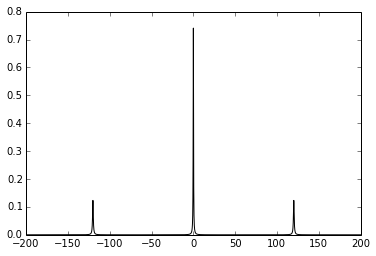

In [22]:
%matplotlib inline
import numpy as np
from scipy.special import *
import matplotlib.pylab as plt

x = np.linspace(-200, 200, 10000)
lw = .01  #[MHz]
beta = 1.0
omega = 120  #[MHz]

lrntzn = lambda x, x0, gamma: 1/(np.pi*2)*gamma/((x-x0)*(x.T-x0) + (gamma/2)**2)

I = jn(0, beta)**2 * lrntzn(x, 0, 0.5) + jn(1, beta)**2 * (lrntzn(x, omega, beta) + lrntzn(x, -omega, beta))

plt.plot(x, I, 'k')





'\nplt.figure()\nplt.plot(wave, flux)\nplt.plot(wave, photo_events)\n'

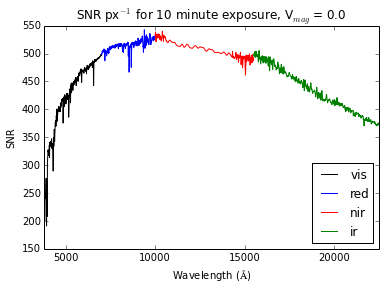

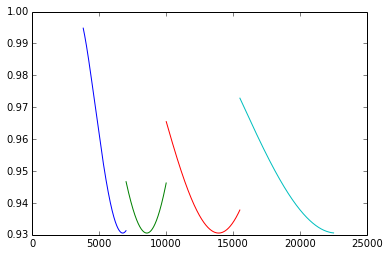

In [203]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy import constants as const
from astropy.utils.data import download_file
from scipy.special import *
import matplotlib.pylab as plt


class SourceSpectra:
    def __init__(self, magnitude, spectral_type):
        self.magnitude = magnitude
        self.spectral_type = spectral_type
        
    def getFlux(self):
        image_file = download_file("ftp://ftp.stsci.edu/cdbs/grid/pickles/dat_uvk/pickles_uk_26.fits", cache=True )  # G2V, zero mag
        hdu_list = fits.open(image_file)
        image_data = hdu_list[1].data

        flux = np.zeros(image_data.shape)
        wav = np.zeros(image_data.shape)
        for x in range(0,int(image_data.shape[0])):
            wav[x] = image_data[x][0]
            flux[x] = image_data[x][1]

        magnitude = 0.0
        flux *= 10**(-self.magnitude/2.5) / (const.h * 1.0e7 * const.c * 1.0e10 / wav)  # [photons sec^-1 cm^-2 angstrom ^-1]
        return flux, wav
    

class Telescope:
    def __init__(self, diameter):
        self.diameter = diameter
        
    def getEffectiveArea(self, scale):
        return np.pi * (self.diameter/2.0)**2 * scale
        
        
        
class Spectrograph:
    def __init__(self, resolution, sampling, QE, throughput):
        self.res = float(resolution)
        self.samp = float(sampling)
        self.qe = QE
        self.thruput = throughput
        
    def getPlateFactor(self, wavelength):
        return wavelength / (self.res * self.samp)
    
    def getThroughput(self, wavelength):
        ''' TBD, add smf fiber link, wavelength dependence'''
        return self.qe * self.thruput

    
    
class SingleModeFiber:
    def __init__(self, core_diameter, NA):
        self.na = NA
        self.core_diameter = core_diameter
        self.Vnum_wave = 2*np.pi * (self.core_diameter / 2.0) * self.na # [V number w/o wavelength dependence]    
        
    def getVNumber(self, wavelength):
        return self.Vnum_wave / wavelength
    
    def getMFD(self, V):
        '''
        Based on Marcuse formula. Tpyically shown as ratio of mode radius to core radius, using core diameter converts to MFD.
        '''
        return self.core_diameter * (0.65 + 1.619/V**(3/2) + 2.879/V**6)
    
    def getThroughput(self, wavelength, beam_waist, offset):
        '''
        Specify wavelength, beam waist, offset in same dimensions as core diameter.
        '''
        mfd = self.getMFD(self.getVNumber(wavelength))
        return 4*mfd**2 * beam_waist**2 / (mfd**2 + beam_waist**2)**2 * np.exp(-2*offset**2 / (mfd**2 + beam_waist**2))
    
    
    
tele = Telescope(20.0)
spx = Spectrograph(150000, 4, 0.9, 0.15)
star = SourceSpectra(0.0, 'G2V')
minutes = 10


### Setup wavelength arrays and fibers    
vsw = 3800
vlw = 7000
rsw = 7000
rlw = 10000
nsw = 10000
nlw = 15500
isw = 15500
ilw = 22500
vis_wav = wave[np.argmin(np.abs(wave-vsw)): np.argmin(np.abs(wave-vlw))]
red_wav = wave[np.argmin(np.abs(wave-rsw)): np.argmin(np.abs(wave-rlw))]
nir_wav = wave[np.argmin(np.abs(wave-nsw)): np.argmin(np.abs(wave-nlw))]
ir_wav = wave[np.argmin(np.abs(wave-isw)): np.argmin(np.abs(wave-ilw))]


### Visible fiber, Thorlabs S405-XP, MFD specs: 3.3±0.5µm @ 405nm; 4.6±0.5µm @ 630nm
core_diam = 3.0  #[um]
NA = 0.12
vis_fiber = SingleModeFiber(core_diam, NA)

### Red fiber, Thorlabs S630-HP, MFD specs: 4.2 ± 0.5 µm @ 630 nm
core_diam = 3.8
NA = 0.12
red_fiber = SingleModeFiber(core_diam, NA)

### NIR fiber, Thorlabs 1060XP, MFD specs: 5.9±0.5µm @ 980nm; 6.2±0.5µm @ 1060nm; 9.5±0.5µm @ 1550nm
core_diam = 5.3
NA = 0.14
nir_fiber = SingleModeFiber(core_diam, NA)

### IR fiber, Thorlabs SM2000, gives core diameter
core_diam = 11.0
NA = 0.11
ir_fiber = SingleModeFiber(core_diam, NA)

vis_spot_diameter = 1.22 * vis_wav / vis_fiber.na * 1e-4
red_spot_diameter = 1.22 * red_wav / red_fiber.na * 1e-4
nir_spot_diameter = 1.22 * nir_wav / nir_fiber.na * 1e-4
ir_spot_diameter = 1.22 * ir_wav / ir_fiber.na * 1e-4
    
    


photo_events, wave = star.getFlux()
flux = photo_events
photo_events = photo_events * tele.getEffectiveArea(0.897) * spx.getPlateFactor(wave) * spx.getThroughput(1.0)

vis_photons = photo_events[np.argmin(np.abs(wave-vsw)): np.argmin(np.abs(wave-vlw))] \
* vis_fiber.getThroughput(vis_wav*1e-4, vis_spot_diameter, 0.0)
red_photons = photo_events[np.argmin(np.abs(wave-rsw)): np.argmin(np.abs(wave-rlw))] \
* red_fiber.getThroughput(red_wav*1e-4, red_spot_diameter, 0.0)
nir_photons = photo_events[np.argmin(np.abs(wave-nsw)): np.argmin(np.abs(wave-nlw))] \
* nir_fiber.getThroughput(nir_wav*1e-4, nir_spot_diameter, 0.0)
ir_photons = photo_events[np.argmin(np.abs(wave-isw)): np.argmin(np.abs(wave-ilw))] \
* ir_fiber.getThroughput(ir_wav*1e-4, ir_spot_diameter, 0.0)



plt.plot(vis_wav, np.sqrt(vis_photons * 60.0 * minutes), 'k', label='vis')
plt.plot(red_wav, np.sqrt(red_photons * 60.0 * minutes), label='red')
plt.plot(nir_wav, np.sqrt(nir_photons * 60.0 * minutes), 'r', label='nir')
plt.plot(ir_wav, np.sqrt(ir_photons * 60.0 * minutes), 'g', label='ir')
plt.legend(loc=0)
plt.xlim([vis_wav[0], ir_wav[-1]])
plt.title("SNR px$^{-1}$ for %s minute exposure, V$_{mag}$ = %s" %(minutes, magnitude))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('SNR')
plt.figure()
plt.plot(vis_wav, vis_fiber.getThroughput(vis_wav*1e-4, vis_spot_diameter, 0.0))
plt.plot(red_wav, red_fiber.getThroughput(red_wav*1e-4, red_spot_diameter, 0.0))
plt.plot(nir_wav, nir_fiber.getThroughput(nir_wav*1e-4, nir_spot_diameter, 0.0))
plt.plot(ir_wav, ir_fiber.getThroughput(ir_wav*1e-4, ir_spot_diameter, 0.0))
'''
plt.figure()
plt.plot(wave, flux)
plt.plot(wave, photo_events)
'''

Get 0 magnitude flux from Pickles database at STScI.
Convert to photons per second per cm^2 per angstrom by dividing by energy per photon, determined with provided wavelengths at flux calibrated points and scaling with desired magnitude.

Determine effective area of telescope and plate factor based on spectrograph specifics specified, include detecto quantum efficiency

Get photon events per second by multiplying flux by plate factor and effective area. Multiplying by the plate factor reduces the photon flux per pixel, spreading it out.

Multiply by exposure to and take square root to get SNR per pixel, roughly speaking.

### Fiber coupling
Efficient coupling into a single mode fiber requires matching light to the mode radius of the fiber. The mode radius of the fiber is estimated by the Marcuse formula. 
$$\frac{w}{a} \approx 0.65 + \frac{1.619}{V^{3/2}} + \frac{2.789}{V^6}$$
with $w$ and $a$ being the radius (or diameter) of the mode and fiber core respectively. $V$ is a normalized frequency parameter that determines the number of supportable modes within a step-index fiber,
$$V=\frac{2\pi}{\lambda}a \mathrm{NA}.$$
It would seem these parameter could be estimated from the wavelength and core diameter but fiber manufacturers/retailers like to only tell you the MFD at a specific wavelength, just above the cutoff. Surveying vendor sights this is actually a very iffy thing. I will just take the short wave MFD, knock it down by a factor of 1.1 and use this a the core diameter. This will likely be an over estimate, like always...

The wavelength at which $V$ becomes $\approx2.45$, a fiber ceases being single-mode. This is called the cutoff frequency or cutoff wavelength and sets the lower limit. The upper limit is tougher, gets lossy due to bend radius/microfracturers etc. The coupling coefficient is 
$$\eta = \frac{4 w_{fib}^2 w_{beam}^2}{(w_{fib}^2+w_{beam}^2)^2} \exp\left(\frac{-2\Delta x^2}{w_{fib}^2+w_{beam}^2}\right),$$
$w_n$ is the beam waist/fiber diameter and $\Delta x$ is the transverse offset.

Incident light from celestial objects will be a plain wave that forms a diffraction limited spot with the appopriate optical system. The spot size can be approximated by the first null of the Airy function, 
$$d=2.44 \: \lambda \: f/\# = 1.22 \lambda \: / \: NA.$$
Where the $NA$ is specified for the optical system but should in fact match the fiber. Thus, without loss of generality, the spot size can be scaled by the NA of the fiber. As the spot size increases, the fiber diameter must too (eventually). 
